This is not my own work, please see this webpage

[Refrence Article](https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html)

In [1]:
import numpy as np
import pandas as pd

In [2]:
from joblib import dump, load

In [3]:
import matplotlib.pyplot as plt

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [5]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Project 

In [6]:
df = pd.read_csv(
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv', 
    sep = ','
)
df = df.rename(columns = {'fecha':'date'}) # not everyone speaks spanish, pero yo si!
df['date'] = pd.to_datetime(df['date'])
df = df.set_index("date")
df = df.sort_index()
df = df.asfreq('MS')
df

,y,exog_1,exog_2
date,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199
...,...,...,...
2008-02-01,0.761822,1.515840,1.786373
2008-03-01,0.649435,1.506258,1.694264
2008-04-01,0.827887,1.505253,1.627135


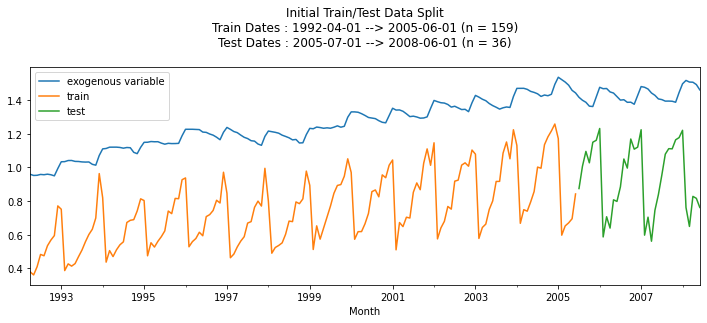

In [9]:
months_for_training = 36
df_train = df[:-months_for_training]
df_test  = df[-months_for_training:]
#
fig, ax = plt.subplots(figsize = (12, 4))
df['exog_1'].plot(ax = ax, label = 'exogenous variable')
df_train['y'].plot(ax = ax, label = 'train')
df_test['y'].plot(ax = ax, label = 'test')
ax.set_title(f'''Initial Train/Test Data Split
Train Dates : {df_train.index.min().date()} --> {df_train.index.max().date()} (n = {len(df_train)})
Test Dates : {df_test.index.min().date()} --> {df_test.index.max().date()} (n = {len(df_test)})
''')
ax.set_xlabel('Month')
ax.legend()

In [10]:
# create the forecasting model
forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(random_state = 420),
    lags = 6
)
# fit to the data
forecaster.fit(y = df_train['y'], exog = df_train['exog_1'])
#
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=420) 
Lags: [1 2 3 4 5 6] 
Window size: 6 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: exog_1 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 420, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-04-17 18:31:50 
Last fit date: 2022-04-17 18:31:51 
Skforecast version: 0.4.3 

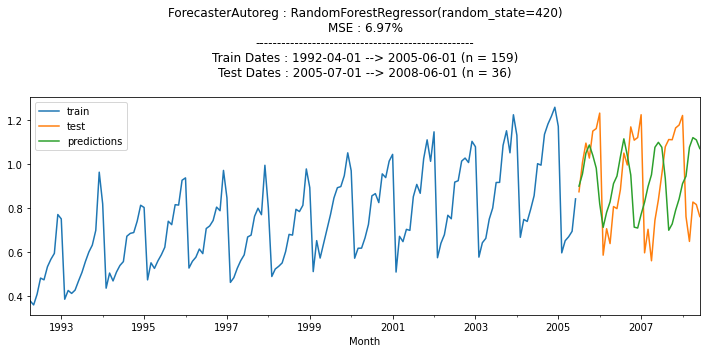

In [11]:
predictions = forecaster.predict(
    steps = months_for_training,
    exog = df_test['exog_1']
)
error_mse = mean_squared_error(
    y_true = df_test['y'],
    y_pred = predictions
)
#
fig, ax = plt.subplots(figsize = (12, 4))
df_train['y'].plot(ax = ax, label = 'train')
df_test['y'].plot(ax = ax, label = 'test')
predictions.plot(ax = ax, label = 'predictions')
ax.set_title(f'''ForecasterAutoreg : {forecaster.regressor}
MSE : {error_mse:.2%}
{'-'*50}
Train Dates : {df_train.index.min().date()} --> {df_train.index.max().date()} (n = {len(df_train)})
Test Dates : {df_test.index.min().date()} --> {df_test.index.max().date()} (n = {len(df_test)})
''')
ax.set_xlabel('Month')
ax.legend()

In [13]:
results_grid = grid_search_forecaster(
    param_grid = {
        'n_estimators': [100, 500],
        'max_depth': [3, 5, 10]
    },
    forecaster = ForecasterAutoreg(
        regressor = RandomForestRegressor(random_state = 420),
        lags = 12 # This value will be replaced in the grid search
    ),
    y = df_train['y'],
    exog = df_train['exog_1'],
    lags_grid = [10, 20],
    steps = months_for_training,
    refit = True,
    metric = 'mean_squared_error',
    initial_train_size  = int(len(df_train)*0.5),
    fixed_train_size = False,
    return_best = True,
    verbose = False
)
#
results_grid

Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:24<00:00, 12.38s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 0.013248222057980586



,lags,params,metric,max_depth,n_estimators
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.013248,5,500
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.013267,3,500
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",0.013534,10,500
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.013570,3,100
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.013687,5,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.013989,10,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",0.036554,3,500
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.036753,5,100
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.038051,3,100
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",0.038225,5,500


In [14]:
# create the forecasting model
forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(
        **results_grid.iloc[0]['params'], 
        random_state = 420
    ),
    lags = results_grid.iloc[0]['lags']
)
# fit to the data
forecaster.fit(y = df_train['y'], exog = df_train['exog_1'])
#
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=5, n_estimators=500, random_state=420) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
Window size: 20 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: exog_1 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 420, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-04-17 18:35:34 
Last fit date: 2022-04-17 18:35:35 
Skforecast version: 0.4.3 

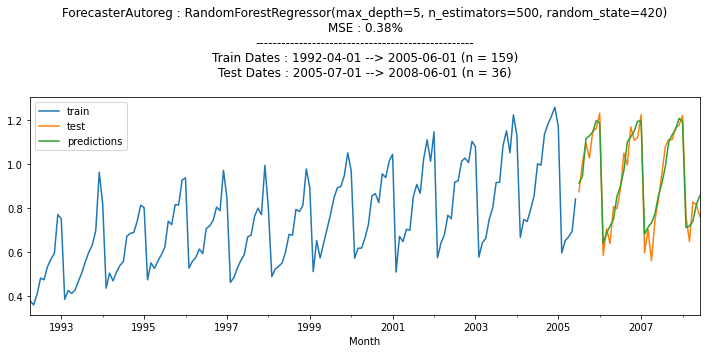

In [15]:
predictions = forecaster.predict(
    steps = months_for_training,
    exog = df_test['exog_1']
)
error_mse = mean_squared_error(
    y_true = df_test['y'],
    y_pred = predictions
)
#
fig, ax = plt.subplots(figsize = (12, 4))
df_train['y'].plot(ax = ax, label = 'train')
df_test['y'].plot(ax = ax, label = 'test')
predictions.plot(ax = ax, label = 'predictions')
ax.set_title(f'''ForecasterAutoreg : {forecaster.regressor}
MSE : {error_mse:.2%}
{'-'*50}
Train Dates : {df_train.index.min().date()} --> {df_train.index.max().date()} (n = {len(df_train)})
Test Dates : {df_test.index.min().date()} --> {df_test.index.max().date()} (n = {len(df_test)})
''')
ax.set_xlabel('Month')
ax.legend()

## Backtesting

Information of backtesting process
----------------------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00



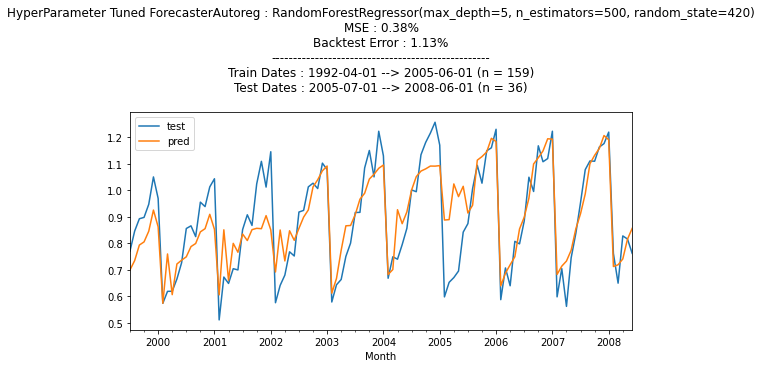

In [17]:
error_backtest, predictions_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y = df['y'],
    exog = df['exog_1'],
    initial_train_size = len(df) - (months_for_training * 3),
    fixed_train_size = False,
    steps = months_for_training,
    metric = 'mean_squared_error',
    refit = True,
    verbose = True
)
#
fig, ax = plt.subplots(figsize=(9, 4))
df.loc[predictions_backtest.index, 'y'].plot(ax = ax, label = 'test')
predictions_backtest.plot(ax = ax, label='predictions')
ax.set_title(f'''HyperParameter Tuned ForecasterAutoreg : {forecaster.regressor}
MSE : {error_mse:.2%}
Backtest Error : {error_backtest:.2%}
{'-'*50}
Train Dates : {df_train.index.min().date()} --> {df_train.index.max().date()} (n = {len(df_train)})
Test Dates : {df_test.index.min().date()} --> {df_test.index.max().date()} (n = {len(df_test)})
''')
ax.set_xlabel('Month')
ax.legend()

In [18]:
forecaster.get_feature_importance().style.format({'importance': '{:,.2%}'.format})

,feature,importance
0,lag_1,1.18%
1,lag_2,9.16%
2,lag_3,1.18%
3,lag_4,0.22%
4,lag_5,0.20%
5,lag_6,0.32%
6,lag_7,0.20%
7,lag_8,0.71%
8,lag_9,0.93%
9,lag_10,1.39%
